# Data import & data processing 

In [33]:
#%% First Part ==> WEB SCRAPING

#******************************Excel file already cleaned for lazy load**************************

#Import necessary packages
import pandas as pd
import re 
import numpy as np
import os
import time
import requests
from bs4 import BeautifulSoup
import datetime
from tqdm import tqdm
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm 
from nltk.stem.porter import PorterStemmer
import itertools
import matplotlib.pyplot as plt

# Get all ECB links via the following excel files
df_lien = pd.read_excel("pc_link.xlsx")
liste_links = np.hstack(df_lien.iloc[:, [1]].values)
print(len(liste_links))

268


In [2]:
#%% only analyze conference >= 99 ==> introduction of €

df = pd.DataFrame(liste_links, columns=['links']) 
df_euro = df[df['links'].str.contains('/press/pressconf/1998/')==False]

# Get date, title, content_subtile & content for each article
liste_links = df.links.values
len(liste_links)

conf_detail = []
for n in tqdm(range(len(liste_links))):
    
    date = ''
    title = ''
    content = ''

    req = requests.get('https://www.ecb.europa.eu'+liste_links[n])
    soup = BeautifulSoup(req.content, 'html.parser')

    for x in soup.find_all(attrs={'property': 'article:published_time'}):
        date = (x['content'])

    for x in soup.find_all(attrs={'property': 'og:title'}):
        title = (x['content'])
    
    # we split the find_all in two because some pages have two splits with added tag lang='en'
    #and w/o specifying the tag, the first part is not included
    #filtered by main to avoid adding text that is not in the body
    main = soup.find('main')
    for x in main.find_all('div', class_='section'): #"div", {"class":"section"} 
        content += x.text  
        
    for x in main.find_all('div', class_='section', lang='en'):
        content += x.text
    conf_detail.append((title, date, content))
    
    
df_conf = pd.DataFrame(conf_detail)

liste_links_in_df = ['https://www.ecb.europa.eu'+l for l in liste_links]
df_conf['liens'] = liste_links_in_df
df_conf = df_conf.rename({0:'title', 1:'date', 2:'content'}, axis=1)
df_conf.sort_values(by='date', inplace=True)
df_conf = df_conf.reset_index(drop=True)
df_conf

100%|██████████| 268/268 [02:03<00:00,  2.16it/s]


,title,date,content,liens
0,ECB Press conference: Introductory statement,1998-06-09,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...
1,ECB Press conference: Introductory statement,1998-07-08,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...
2,ECB Press conference: Introductory statement,1998-09-11,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...
3,ECB Press conference: Introductory statement,1998-10-13,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...
4,ECB Press conference: Introductory statement,1998-11-03,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...
...,...,...,...,...
263,Monetary policy statement (with Q&A),2022-06-09,"Christine Lagarde, President of the ECB,Luis d...",https://www.ecb.europa.eu/press/pressconf/2022...
264,Monetary policy statement (with Q&A),2022-07-21,"Christine Lagarde, President of the ECB,Luis d...",https://www.ecb.europa.eu/press/pressconf/2022...
265,Monetary policy statement (with Q&A),2022-09-08,"Christine Lagarde, President of the ECB,Luis d...",https://www.ecb.europa.eu/press/pressconf/2022...
266,Monetary Policy,2022-09-15,\nWe take decisions on monetary policy every s...,https://www.ecb.europa.eu/press/pressconf/visu...


In [3]:
#%%************************CONTENT CLEANING************************************

# we remove from the texts the sentence Jump to the transcript
# in order to avoid the word 'Jump' being analyzed as a meaningful word
for i, content in enumerate(df_conf['content']):
    #content = remove_punctuation(content)
    if "Jump to the transcript" in content:
        df_conf.at[i, 'content'] = content.replace("Jump to the transcript", "")

# delete q&A part from the content 
for i, content in enumerate(df_conf['content']):
    # Find the index of the text
    idx1 = content.find('We are now ready to take your questions.')
    idx2 = content.find('We are now at your disposal for questions.')
    idx3 = content.find('We are now at your disposal, should you have any questions.')
    idx4 = content.find('Transcript of the questions asked and the answers given by')
    idx5 = content.find('We stand ready to answer any questions you may have.')

    if idx1 > 0:
        df_conf.at[i,'content'] = content[:idx1]

    elif idx2 > 0:
        df_conf.at[i,'content'] = content[:idx2]

    elif idx3 > 0:
        df_conf.at[i,'content'] = content[:idx3]

    elif idx4 > 0:
        df_conf.at[i,'content'] = content[:idx4]

    elif idx5 > 0:
        df_conf.at[i,'content'] = content[:idx5]

df_conf = df_conf.set_index('date')
# Here we drop an unnecessary conf (a visual without text) 
df_conf = df_conf.drop('2022-09-15')
df_conf


,title,content,liens
date,,,
1998-06-09,ECB Press conference: Introductory statement,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...
1998-07-08,ECB Press conference: Introductory statement,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...
1998-09-11,ECB Press conference: Introductory statement,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...
1998-10-13,ECB Press conference: Introductory statement,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...
1998-11-03,ECB Press conference: Introductory statement,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...
...,...,...,...
2022-04-14,Monetary policy statement (with Q&A),"Christine Lagarde, President of the ECB,Luis d...",https://www.ecb.europa.eu/press/pressconf/2022...
2022-06-09,Monetary policy statement (with Q&A),"Christine Lagarde, President of the ECB,Luis d...",https://www.ecb.europa.eu/press/pressconf/2022...
2022-07-21,Monetary policy statement (with Q&A),"Christine Lagarde, President of the ECB,Luis d...",https://www.ecb.europa.eu/press/pressconf/2022...


In [4]:
#%%*********************CONTENT CLEANING*********************************
#importing nltk stop word
#we chose nltk in order not to restrict many useful words in our analysis''' 
stops = list(stopwords.words('english'))

#function that cleans the content by converting to lower case + deleting 
#punct and tokenizing each word + remove stop words'''
def clean(x):
    x = x.lower()
    x = re.sub(r'[^\w\s]', '', x)
    x = word_tokenize(x)
    x = [w for w in x if w not in stops]    
    return(x)

df_conf['transform'] = [clean(i) for i in (df_conf['content'])]

#%%************************STEMMING********************************************

# we used Porter stemmer which was used by the authors
stemmer = PorterStemmer()
df_conf['stem'] = df_conf['transform'].apply(lambda x: [stemmer.stem(token) for token in x])
df_conf

,title,content,liens,transform,stem
date,,,,,
1998-06-09,ECB Press conference: Introductory statement,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...,"[willem, f, duisenberg, president, european, c...","[willem, f, duisenberg, presid, european, cent..."
1998-07-08,ECB Press conference: Introductory statement,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...,"[willem, f, duisenberg, president, european, c...","[willem, f, duisenberg, presid, european, cent..."
1998-09-11,ECB Press conference: Introductory statement,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...,"[willem, f, duisenberg, president, european, c...","[willem, f, duisenberg, presid, european, cent..."
1998-10-13,ECB Press conference: Introductory statement,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...,"[willem, f, duisenberg, president, european, c...","[willem, f, duisenberg, presid, european, cent..."
1998-11-03,ECB Press conference: Introductory statement,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...,"[willem, f, duisenberg, president, european, c...","[willem, f, duisenberg, presid, european, cent..."
...,...,...,...,...,...
2022-04-14,Monetary policy statement (with Q&A),"Christine Lagarde, President of the ECB,Luis d...",https://www.ecb.europa.eu/press/pressconf/2022...,"[christine, lagarde, president, ecbluis, de, g...","[christin, lagard, presid, ecblui, de, guindo,..."
2022-06-09,Monetary policy statement (with Q&A),"Christine Lagarde, President of the ECB,Luis d...",https://www.ecb.europa.eu/press/pressconf/2022...,"[christine, lagarde, president, ecbluis, de, g...","[christin, lagard, presid, ecblui, de, guindo,..."
2022-07-21,Monetary policy statement (with Q&A),"Christine Lagarde, President of the ECB,Luis d...",https://www.ecb.europa.eu/press/pressconf/2022...,"[christine, lagarde, president, ecbluis, de, g...","[christin, lagard, presid, ecblui, de, guindo,..."


In [5]:
#%%********************SIMILARITY MEASURE**************************************
#**********we used jaccard similarity which was the one used in the paper

#function that renders jaccard similarity
def jaccard_similarity(set_1, set_2):
    # Convert the sets to lists
    list_1 = list(set_1)
    list_2 = list(set_2)
    
    # Find the intersection of the lists
    intersection = len(set(list_1).intersection(list_2))
    
    # Find the union of the lists
    union = len(set(list_1).union(list_2))
    
    # Calculate the Jaccard similarity score
    jaccard_similarity = intersection / union
    return jaccard_similarity

# applying similarity to the data
jaccard_sim = []
#Insert NaN for the first element of the list
jaccard_sim.insert(0, np.NaN)

for i in range(len(df_conf['stem'])):
    try:
        jaccard_sim.append(jaccard_similarity(df_conf['stem'][i], df_conf['stem'][i+1]))
    except:
        print(i)
        pass
    
df_conf.reset_index(inplace=True)
df_conf['jaccard_similarity'] = jaccard_sim
df_conf

266


,date,title,content,liens,transform,stem,jaccard_similarity
0,1998-06-09,ECB Press conference: Introductory statement,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...,"[willem, f, duisenberg, president, european, c...","[willem, f, duisenberg, presid, european, cent...",NaN
1,1998-07-08,ECB Press conference: Introductory statement,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...,"[willem, f, duisenberg, president, european, c...","[willem, f, duisenberg, presid, european, cent...",0.230645
2,1998-09-11,ECB Press conference: Introductory statement,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...,"[willem, f, duisenberg, president, european, c...","[willem, f, duisenberg, presid, european, cent...",0.338101
3,1998-10-13,ECB Press conference: Introductory statement,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...,"[willem, f, duisenberg, president, european, c...","[willem, f, duisenberg, presid, european, cent...",0.336590
4,1998-11-03,ECB Press conference: Introductory statement,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...,"[willem, f, duisenberg, president, european, c...","[willem, f, duisenberg, presid, european, cent...",0.351073
...,...,...,...,...,...,...,...
262,2022-04-14,Monetary policy statement (with Q&A),"Christine Lagarde, President of the ECB,Luis d...",https://www.ecb.europa.eu/press/pressconf/2022...,"[christine, lagarde, president, ecbluis, de, g...","[christin, lagard, presid, ecblui, de, guindo,...",0.486137
263,2022-06-09,Monetary policy statement (with Q&A),"Christine Lagarde, President of the ECB,Luis d...",https://www.ecb.europa.eu/press/pressconf/2022...,"[christine, lagarde, president, ecbluis, de, g...","[christin, lagard, presid, ecblui, de, guindo,...",0.433043
264,2022-07-21,Monetary policy statement (with Q&A),"Christine Lagarde, President of the ECB,Luis d...",https://www.ecb.europa.eu/press/pressconf/2022...,"[christine, lagarde, president, ecbluis, de, g...","[christin, lagard, presid, ecblui, de, guindo,...",0.461538
265,2022-09-08,Monetary policy statement (with Q&A),"Christine Lagarde, President of the ECB,Luis d...",https://www.ecb.europa.eu/press/pressconf/2022...,"[christine, lagarde, president, ecbluis, de, g...","[christin, lagard, presid, ecblui, de, guindo,...",0.471971


In [6]:
#%%***********************MEASURING PESSIMISM**********************************
# to measure pessimism we used Loughran-McDonald since it has more accurate
#lexicon for our analysis (financial lexicon)
df_conf['pessimism'] = np.NaN
df_conf['pessimism_2'] = np.NaN
# for pessimism we didn't lemmatize because LM has all variants of a word
#retrieve the LM database
lm = pd.read_csv('Loughran-McDonald_MasterDictionary_1993-2021.csv')      
lm["Word"] = lm["Word"].astype(str)

neg_list = list(lm[lm["Negative"] !=0]["Word"])
pos_list = list(lm[lm["Positive"] !=0]["Word"])

neg_list = [x.lower() for x in neg_list]
pos_list = [x.lower() for x in pos_list]

for i in tqdm(range(len(df_conf))):
    content = df_conf['transform'][i]
    neg_words = []
    pos_words = []
    for token in content:
        if token in neg_list:
            neg_words.append(token)
        if token in pos_list:
            pos_words.append(token)
    # We add below an epsilon value of 1**-10 in the case of the same nb of neg words and pos words (therefore 
    #yielding a canot divide by 0 error)
    df_conf.loc[i, 'pessimism']  = (len(neg_words) - len(pos_words)) / (len(neg_words) + len(pos_words)+1**-10)
    df_conf.loc[i, 'pessimism_2'] = (len(neg_words) - len(pos_words)) / len(content)
df_conf

100%|██████████| 267/267 [00:25<00:00, 10.46it/s]


,date,title,content,liens,transform,stem,jaccard_similarity,pessimism,pessimism_2
0,1998-06-09,ECB Press conference: Introductory statement,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...,"[willem, f, duisenberg, president, european, c...","[willem, f, duisenberg, presid, european, cent...",NaN,0.750000,0.004630
1,1998-07-08,ECB Press conference: Introductory statement,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...,"[willem, f, duisenberg, president, european, c...","[willem, f, duisenberg, presid, european, cent...",0.230645,0.114286,0.002460
2,1998-09-11,ECB Press conference: Introductory statement,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...,"[willem, f, duisenberg, president, european, c...","[willem, f, duisenberg, presid, european, cent...",0.338101,0.509804,0.015971
3,1998-10-13,ECB Press conference: Introductory statement,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...,"[willem, f, duisenberg, president, european, c...","[willem, f, duisenberg, presid, european, cent...",0.336590,0.387218,0.022425
4,1998-11-03,ECB Press conference: Introductory statement,"\nWillem F. Duisenberg, President of the Europ...",https://www.ecb.europa.eu/press/pressconf/1998...,"[willem, f, duisenberg, president, european, c...","[willem, f, duisenberg, presid, european, cent...",0.351073,0.181818,0.006680
...,...,...,...,...,...,...,...,...,...
262,2022-04-14,Monetary policy statement (with Q&A),"Christine Lagarde, President of the ECB,Luis d...",https://www.ecb.europa.eu/press/pressconf/2022...,"[christine, lagarde, president, ecbluis, de, g...","[christin, lagard, presid, ecblui, de, guindo,...",0.486137,0.666667,0.041725
263,2022-06-09,Monetary policy statement (with Q&A),"Christine Lagarde, President of the ECB,Luis d...",https://www.ecb.europa.eu/press/pressconf/2022...,"[christine, lagarde, president, ecbluis, de, g...","[christin, lagard, presid, ecblui, de, guindo,...",0.433043,0.396552,0.022727
264,2022-07-21,Monetary policy statement (with Q&A),"Christine Lagarde, President of the ECB,Luis d...",https://www.ecb.europa.eu/press/pressconf/2022...,"[christine, lagarde, president, ecbluis, de, g...","[christin, lagard, presid, ecblui, de, guindo,...",0.461538,0.326923,0.019608
265,2022-09-08,Monetary policy statement (with Q&A),"Christine Lagarde, President of the ECB,Luis d...",https://www.ecb.europa.eu/press/pressconf/2022...,"[christine, lagarde, president, ecbluis, de, g...","[christin, lagard, presid, ecblui, de, guindo,...",0.471971,0.528302,0.030668


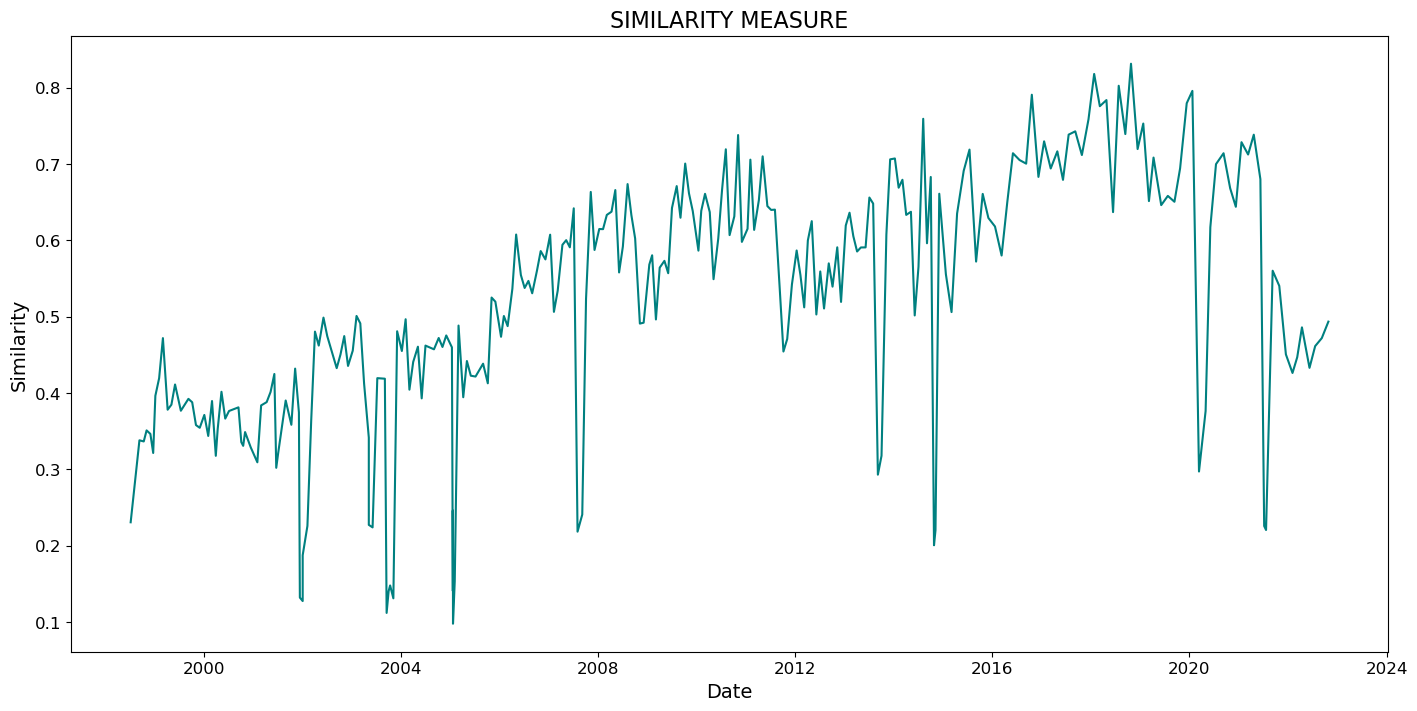

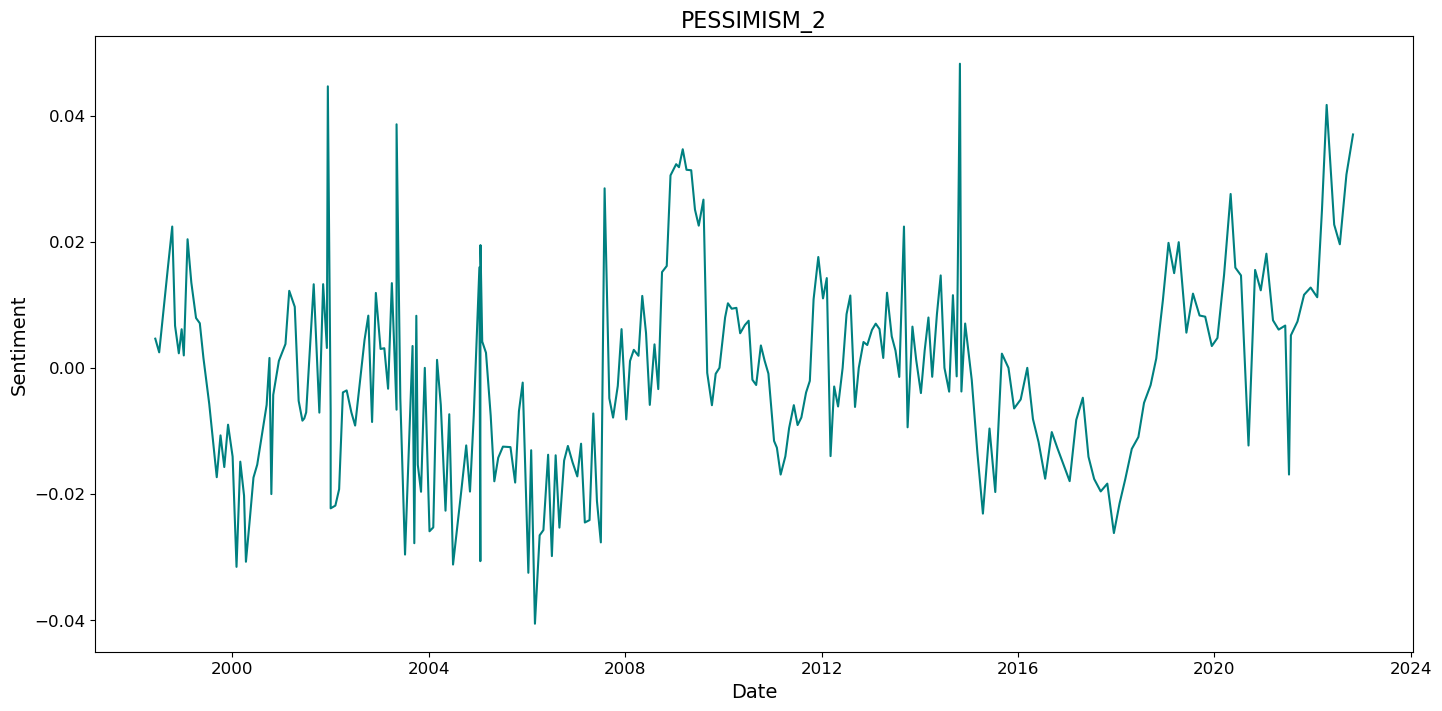

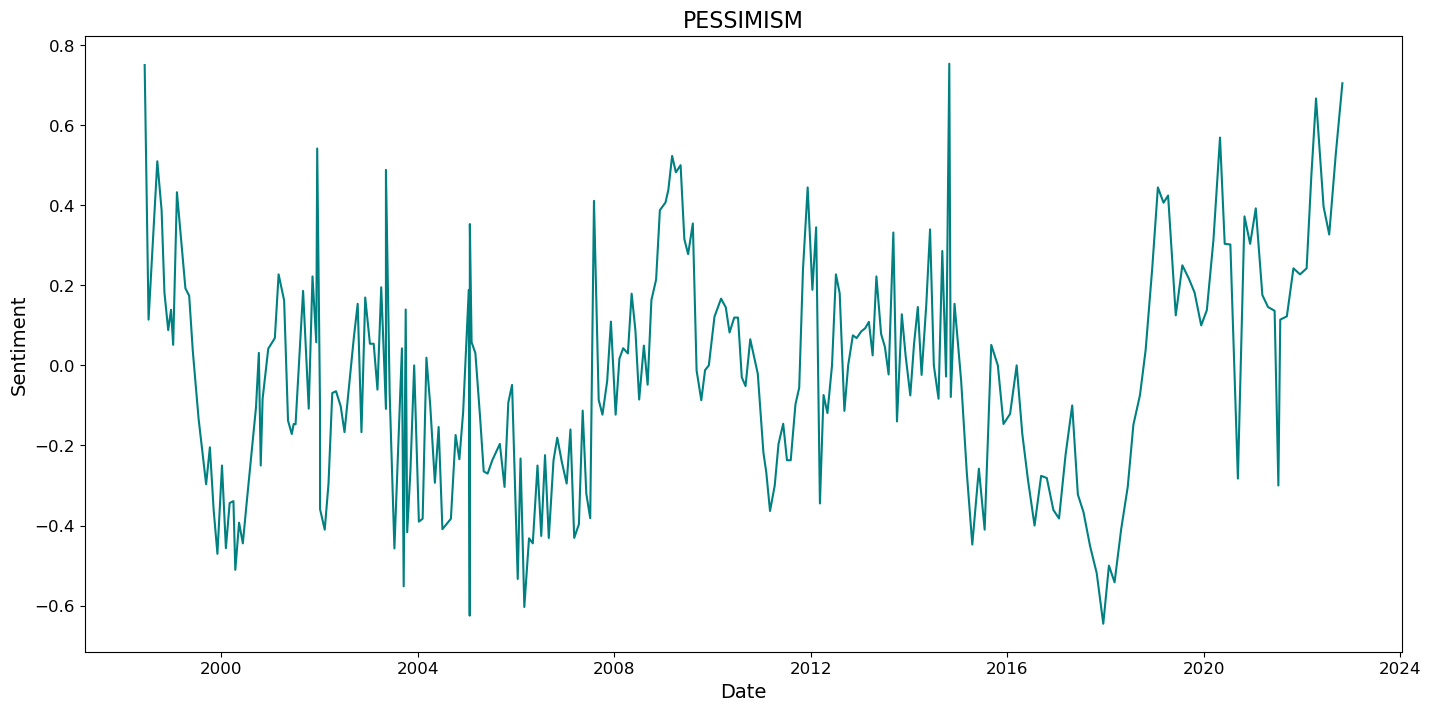

In [7]:
#%%******************************PLOTTING**************************************
# plotting function to be applied to every measure 
df_conf.rename(columns={'date': 'Date'}, inplace=True)
def plot_result(df, x, y, title, xlabel, ylabel, color):
    # Create a figure and set the size
    plt.figure(figsize=(17, 8))

    # Plot the specified columns using the specified color
    plt.plot(df[x], df[y], color=color)
    
    # Add a title and axis labels
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.grid()

    # Show the plot
    plt.show()


# Convert 'date' column to datetime format in date_2 just for visualisation
df_conf['date_2'] = pd.to_datetime(df_conf['Date'])


#plot  similarity
plot_result(df_conf, 'date_2', 'jaccard_similarity', 'SIMILARITY MEASURE', 'Date', 'Similarity', 'teal')
# plot sentiment_2 which the one used in the paper
plot_result(df_conf, 'date_2', 'pessimism_2', 'PESSIMISM_2', 'Date', 'Sentiment', 'teal')
#plot pessimism 1 
plot_result(df_conf, 'date_2', 'pessimism', 'PESSIMISM', 'Date', 'Sentiment', 'teal')


In [8]:

#%%***********************CALCULATING TIME ELAPSED*****************************
from datetime import datetime

# function to calculate time elapsed since 1999-01-01 in days
def days_since_1999(date):
    start_date = datetime(1999, 1, 1)
    end_date = date
    return (end_date - start_date).days


dt = [days_since_1999(i) for i in df_conf['date_2']]
df_conf['diff'] = dt
    
#%%***********************CLEAN DATASET FOR NLP PART***************************

reg_df = df_conf[['Date', 'jaccard_similarity', 'pessimism', 'pessimism_2', 'diff']]
reg_df = reg_df.rename(columns={'date': 'Date'})

reg_df

,Date,jaccard_similarity,pessimism,pessimism_2,diff
0,1998-06-09,NaN,0.750000,0.004630,-206
1,1998-07-08,0.230645,0.114286,0.002460,-177
2,1998-09-11,0.338101,0.509804,0.015971,-112
3,1998-10-13,0.336590,0.387218,0.022425,-80
4,1998-11-03,0.351073,0.181818,0.006680,-59
...,...,...,...,...,...
262,2022-04-14,0.486137,0.666667,0.041725,8504
263,2022-06-09,0.433043,0.396552,0.022727,8560
264,2022-07-21,0.461538,0.326923,0.019608,8602
265,2022-09-08,0.471971,0.528302,0.030668,8651


In [9]:
#%%***********************GETTING EUROSTOCK DATA*******************************

#import Eurostock daily data from Boursorama
df_eurostock = pd.read_csv('Eurostock.txt', sep='\t')
df_eurostock = df_eurostock.rename(columns={'date': 'Date'})

# convert Date to datetime
df_eurostock['Date'] = pd.to_datetime(df_eurostock['Date'], format='%d/%m/%Y')

# Computing the CAR
# Apply the log to our variable
df_eurostock['last'] = list(map(lambda x: np.log(x), df_eurostock['close']))
df_eurostock['pct_change'] = np.NaN
df_eurostock['pct_change'] = df_eurostock['last'].diff(1)
df_eurostock.dropna(inplace=True)
df_eurostock_to_np = df_eurostock['pct_change'].to_numpy()

window_value_abnormal_return = {}
window_value_car = {}

df_eurostock['cumulate'] = np.NaN
df_eurostock['CAR'] = np.NaN

# Compute the 1st window value -> corresponds at date t, to the mean of the return from t-250 to t-50. 
# Append the results to a dic with index as key and results as value (more efficient than lists). 
for n in (range(len(df_eurostock_to_np))):
    x = df_eurostock_to_np[n-251:n-50]
    window_value_abnormal_return[n] = 1/201*(np.sum(x))
liste_cumu = list(window_value_abnormal_return.values())
df_eurostock.cumulate = liste_cumu
df_eurostock['abnormal_return'] = np.NaN

# We then compute abnormal returns
#df_eurostock['abnormal_return'] = df_eurostock['pct_change'] - abs(df_eurostock['cumulate'])
df_eurostock['abnormal_return'] = df_eurostock['pct_change'] - df_eurostock['cumulate']
df_eurostock_car_to_np = df_eurostock['abnormal_return'].to_numpy()

#  Computation of cumulative abnormal returns via the same method used above
for n in (range(len(df_eurostock_car_to_np))):
  x = df_eurostock_car_to_np[n-6:n+5]
  window_value_car[n] = np.sum(x)
liste_car= list(window_value_car.values())
df_eurostock.CAR = liste_car

df_eurostock['Date'] = df_eurostock['Date'].astype('datetime64[ns]')
df_eurostock.rename(columns = {'last':'eurostock_last','pct_change':'eurostock_pct_change','cumulate':'eurostock_cumulate',
                               'abnormal_return':'eurostock_abnormal_return', 'CAR':'eurostock_CAR'}, inplace = True)

df_eurostock['Date'] = pd.to_datetime(df_eurostock['Date'], format='%d/%m/%Y')

# retrieving Eurostock CAR results in a new df
df_eurostock_final = df_eurostock.loc[:,['Date', 'eurostock_cumulate', 'eurostock_abnormal_return', 'eurostock_CAR']]
df_eurostock_final

,Date,eurostock_cumulate,eurostock_abnormal_return,eurostock_CAR
1,1998-03-09,-0.000964,0.011708,0.000000
2,1998-03-10,-0.001036,-0.000122,0.000000
3,1998-03-11,-0.001004,0.006181,0.000000
4,1998-03-12,-0.000922,-0.001265,0.000000
5,1998-03-13,-0.000844,0.011575,0.000000
...,...,...,...,...
6315,2022-12-23,-0.001260,-0.000384,-0.033813
6316,2022-12-27,-0.001273,0.005424,0.000923
6317,2022-12-28,-0.001213,-0.005086,0.008137
6318,2022-12-29,-0.001104,0.011876,0.005050


In [10]:
#%%*************************MERGING ALL DATA SETS ******************************
## Convert monthly to daily for HICP
df_hicp = pd.read_excel('Data_Applied_DS.xlsx', 'HICP')
df_hicp['Date'] = pd.to_datetime(df_hicp['Date'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m')
df_hicp.Date = df_hicp.Date.apply(lambda x: str(x).replace(x, x+'-01'))
df_hicp['Date'] = df_hicp['Date'].astype('datetime64[ns]')

## Convert monthly to daily for output_gap 
df_ogap = pd.read_excel('Data_Applied_DS.xlsx', 'Output Gap')
df_ogap = df_ogap.rename(columns={'year ': 'Date'})
df_ogap = df_ogap.set_index('Date')
df_ogap_daily = df_ogap['Output_Gap'].resample('D').mean()
df_ogap_daily = df_ogap_daily.interpolate()
# reset index and date as column
df_ogap_daily = df_ogap_daily.reset_index(name='output_gap')
# convert to YYYY-MM
df_ogap_daily['Date'] = pd.to_datetime(df_ogap_daily['Date'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m')
df_ogap_daily.Date = df_ogap_daily.Date.apply(lambda x: str(x).replace(x, x+'-01'))
df_ogap_daily['Date'] = df_ogap_daily['Date'].astype('datetime64[ns]')

## Convert monthly to daily for mro 
from datetime import datetime
#import monthly and cleaning date columns
df_mro = pd.read_excel('data_mro.xlsx')
df_mro.Date = df_mro.Date.apply(lambda x: str(x).replace('.', ''))
df_mro['Date_'] = df_mro['Date'].astype(str) + ' ' + df_mro['Date (with effect from)'].astype(str)
df_mro.drop(columns={'Date (with effect from)', 'Date'}, inplace=True)
df_mro.Date_ = df_mro.Date_.apply(lambda x: str(x).replace(' ', '-'))
df_mro.Date_ = df_mro.Date_.apply(lambda x: datetime.strptime(x, '%d-%b-%Y'))
df_mro = df_mro.rename(columns={'Date_': 'Date', 'MRO - Rate': 'Rate'})
df_mro['Rate'] = df_mro['Rate'].astype(float)

#Interpolation to get daily MRO
df_mro = df_mro.set_index('Date')
df_mro_daily = df_mro['Rate'].resample('D').mean()
df_mro_daily = df_mro_daily.interpolate()
#reset index and date as column
df_mro_daily = df_mro_daily.reset_index(name='mro')
# convert to YYYY-MM
df_mro_daily['Date'] = pd.to_datetime(df_mro_daily['Date'])

In [11]:
## Create date column and convert it to dataframe
from datetime import timedelta, date

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

date_ = []
start_dt = date(1997, 1, 1)
end_dt = date(2022, 12, 31)
for dt in daterange(start_dt, end_dt):
    date_.append(dt.strftime("%Y-%m-%d"))
df_date = pd.DataFrame(date_, columns=['Date'])
df_date['Date'] = df_date['Date'].astype('datetime64[ns]')

In [36]:
import warnings
warnings.filterwarnings("ignore")

## join date col & reg_df
df_not_clean = pd.merge(df_date,df_eurostock_final,how='left',on=['Date'])
df_not_clean_1 = pd.merge(df_not_clean,df_hicp,how='left',on=['Date'])
df_not_clean_2 = pd.merge(df_not_clean_1,df_ogap_daily,how='left',on=['Date'])
df_not_clean_3 = pd.merge(df_not_clean_2,df_mro_daily,how='left',on=['Date'])

df_conf.rename(columns={'date':'Date'}, inplace=True)
df_conf['Date'] = df_conf['Date'].astype('datetime64[ns]')

df_final_not_clean = pd.merge(df_not_clean_3,df_conf,how='left',on=['Date'])

df_final_not_clean.set_index('Date', inplace=True)
df_final_not_clean.dropna(axis = 0, how = 'all', inplace = True)
df_final_not_clean.reset_index(inplace=True)

# Interpolate our variables with a daily granularity
df_final_not_clean.HICP = df_final_not_clean.HICP.interpolate()
df_final_not_clean.output_gap = df_final_not_clean.output_gap.interpolate()
df_final_not_clean.mro = df_final_not_clean.mro.interpolate()

df_final_not_clean.dropna(subset= ['liens'], inplace=True)
df_final_not_clean = df_final_not_clean [['Date','jaccard_similarity','pessimism','pessimism_2','eurostock_cumulate',
                                         'eurostock_abnormal_return', 'eurostock_CAR', 'HICP', 'output_gap', 'mro', 'diff']]

df_final_not_clean.drop_duplicates(subset=['jaccard_similarity','diff'], inplace=True)

#Calculating MRO returns
df_final_not_clean['change_MRO_Rate'] = df_final_not_clean['mro'].diff(1)

#Calculating log for similarity and for Time variable (log_diff)
df_final_not_clean['log_similarity'] = np.log(df_final_not_clean['jaccard_similarity'])
df_final_not_clean['log_diff'] = np.log(df_final_not_clean['diff'].values)

# filling in the remaining missing data w/ latest value
df_final_not_clean.eurostock_cumulate.ffill(inplace=True)
df_final_not_clean.eurostock_abnormal_return.ffill(inplace=True)
df_final_not_clean.eurostock_CAR.ffill(inplace=True)


df_final_not_clean.reset_index(inplace=True, drop=True)
df_final_not_clean = df_final_not_clean[df_final_not_clean.Date > '1998-12-31']
df_final_not_clean

,Date,jaccard_similarity,pessimism,pessimism_2,eurostock_cumulate,eurostock_abnormal_return,eurostock_CAR,HICP,output_gap,mro,diff,change_MRO_Rate,log_similarity,log_diff
7,1999-01-07,0.396440,0.051282,0.001970,0.000000,-0.015723,0.010585,73.788800,0.623945,NaN,6.0,NaN,-0.925230,1.791759
8,1999-02-04,0.419463,0.432432,0.020408,0.000000,-0.000301,-0.032050,73.962500,0.738796,2.915584,34.0,NaN,-0.868780,3.526361
9,1999-03-04,0.472015,0.324324,0.013529,0.000000,0.011874,-0.015026,74.174194,0.866151,2.733766,62.0,-0.181818,-0.750745,4.127134
10,1999-04-08,0.378182,0.192308,0.007911,0.000479,0.002195,0.052052,74.411667,0.990000,2.506494,97.0,-0.227273,-0.972380,4.574711
11,1999-05-06,0.384778,0.173913,0.007080,0.000293,-0.004543,-0.024127,74.450000,1.117101,2.564286,125.0,0.057792,-0.955089,4.828314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,2022-04-14,0.486137,0.666667,0.041725,0.000250,0.005148,-0.022077,115.526000,0.400000,0.450144,8504.0,0.016779,-0.721265,9.048292
263,2022-06-09,0.433043,0.396552,0.022727,-0.000328,-0.016837,-0.067299,117.044667,0.400000,0.476989,8560.0,0.026846,-0.836917,9.054855
264,2022-07-21,0.461538,0.326923,0.019608,-0.000585,0.003723,0.039933,117.598065,0.400000,0.497124,8602.0,0.020134,-0.773190,9.059750
265,2022-09-08,0.471971,0.528302,0.030668,-0.000822,0.003756,0.011352,119.673000,0.400000,1.158163,8651.0,0.661040,-0.750838,9.065430


# Regression part of original paper (replication of results) 

In [37]:
#%%***************************VARIABLES USED***********************************

# VARIABLE NAME IN PAPER ====> VARIABLE NAME IN OUR CODE

# Time ======================> log_diff
# Output gap ================> output_gap
# Inflation =================> HICP
# Delta MRO =================> change_MRO_Rate
# Pessimism =================> pessimism_2
# Pessimism x similarity ====> interaction


#%%***************REPLICATE PAPER RESULTS UP TO 2013-12-31*********************
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

#Creating a new df with replicate data
df_replicate = df_final_not_clean[df_final_not_clean['Date'] <='2013-12-31'] 

#exlude first row to avoid na 
df_replicate = df_replicate.iloc[2:]

# fit linear regression 
def fit_linear_regression(y,x):
    # Add a constant to the predictor variables
    x = sm.add_constant(x)
    
    # Fit a linear regression model
    model = sm.OLS(y, x).fit()
    
    # View the model summary
    print(model.summary())
    
    return model

In [ ]:
# REPLICATING REGRESSION RESULTS OF TABLE 3 (in original paper)

# fit_linear_regression(df_replicate['log_similarity'].dropna(), df_replicate[['output_gap', 'HICP', 'change_MRO_Rate']].dropna())

# fit_linear_regression(df_replicate['log_similarity'].dropna(), df_replicate['log_diff'].dropna())

# fit_linear_regression(df_replicate['log_similarity'].dropna(), df_replicate[['log_diff', 'output_gap', 'change_MRO_Rate']].dropna())

# fit_linear_regression(df_replicate['log_similarity'].dropna(), df_replicate[['output_gap', 'HICP', 'change_MRO_Rate']].dropna())


#calculating CAR absolute value
df_replicate['CAR_abs'] = df_replicate['eurostock_CAR'].abs()
#calculating interaction
df_replicate['interaction'] = df_replicate['pessimism_2'] * df_replicate['jaccard_similarity']

# We didn't include the Time (count) variable below

# REPLICATING REGRESSION RESULTS OF TABLE 4 (in original paper)

# fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['pessimism_2']].dropna()) 

# fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['output_gap', 'HICP', 'change_MRO_Rate']].dropna()) 

# fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['interaction']].dropna()) 

# fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['interaction', 'output_gap', 'HICP', 'change_MRO_Rate']].dropna()) 

# fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['interaction', 'output_gap', 'HICP', 'pessimism_2']].dropna()) 

# Extension part of original paper  


In [44]:
#%%******************EXTEND PAPER RESULTS UP TO 2022-12-31*********************
#Creating a df_final with all data
# cleaning all data set
df_final = df_final_not_clean.iloc[2:]
# complete output gaps missing values with latest value
#df_final.output_gap = df_final.output_gap.ffill()

#delete last row

# Get the last row
last_row = df_final.tail(1)

# Drop the last row
df_final = df_final.drop(last_row.index)

# EXTENDING REGRESSION RESULTS OF TABLE 3

#fit_linear_regression(df_final['log_similarity'].dropna(), df_final[['output_gap', 'HICP', 'change_MRO_Rate']].dropna())

#fit_linear_regression(df_final['log_similarity'].dropna(), df_final['log_diff'].dropna())

fit_linear_regression(df_final['log_similarity'].dropna(), df_final[['log_diff']].dropna())

fit_linear_regression(df_final['log_similarity'].dropna(), df_final[['HICP']].dropna())


                            OLS Regression Results                            
Dep. Variable:         log_similarity   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     82.02
Date:                Tue, 07 Mar 2023   Prob (F-statistic):           3.61e-17
Time:                        10:43:42   Log-Likelihood:                -86.746
No. Observations:                 257   AIC:                             177.5
Df Residuals:                     255   BIC:                             184.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3871      0.187    -12.771      0.0

*** We can here conclude that 1) ECB reports tend to be more similar on higher inflation times and 2) ECB reports tend to be more similar with time. Both these results are highly significant. 

In [51]:
#calculating CAR absolute value
df_final['CAR_abs'] = df_final['eurostock_CAR'].abs()
#calculating interaction
df_final['interaction'] = df_final['pessimism_2'] * df_final['jaccard_similarity']

# EXTENDING REGRESSION RESULTS OF TABLE 4
print('m1 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m1 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['pessimism_2']].dropna()) 
print('m2 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m2 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['output_gap', 'HICP', 'change_MRO_Rate']].dropna()) 
print('m3 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m3 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction']].dropna()) 
#print('m4 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
#m4 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction', 'output_gap', 'HICP', 'change_MRO_Rate']].dropna()) 
#print('m5 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
#m5 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction', 'output_gap', 'HICP', 'pessimism_2']].dropna()) 


m1 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                CAR_abs   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.915
Date:                Tue, 07 Mar 2023   Prob (F-statistic):             0.0890
Time:                        11:04:11   Log-Likelihood:                 498.39
No. Observations:                 257   AIC:                            -992.8
Df Residuals:                     255   BIC:                            -985.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
     

Here we report the estimation results aiming to explain the absolute cumulative abnormal returns of the euro area. We can conclude that the stock market in the Eurozone reacts to the information provided in communication from the European Central Bank (ECB). Specifically, there is a slightly significant and positive relationship between the level of pessimism in the ECB’s announcement and the market’s reaction to it. Furthermore, we observe the interaction term—that condition on the level of ECB communication similarity, this relationship tends to be enhanced. In other words, assuming high similarity, the more pessimistic the announcement, the more strongly the market is likely to react.

An interesting result not documented in Amaya and Filbien (2015) is the negative and statistically significant effect of output gap on cumulative abnormal return. This effect was not significant in the mentioned paper but the coefficient has the same sign. One reason to explain this result is that an increase in the output gap—i.e. high difference between actual output and potential GDP—is negatively interpreted by the stock market as it implies poor performance of the economy; and investors build their expectations accordingly.

In [27]:
#%%*****************************SUMMARY STATISTICS*****************************

#df_final['CAR_abs'].describe()
def summarize_dataframe(df):
    summary = df.describe().T
    summary = summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    return summary

summary = summarize_dataframe(df_final)
summary

,mean,std,min,25%,50%,75%,max
jaccard_similarity,0.525639,0.158263,0.097720,0.422747,0.554622,0.642593,0.831606
pessimism,-0.038839,0.274145,-0.645161,-0.250000,-0.048193,0.145833,0.753363
pessimism_2,-0.001618,0.015509,-0.040603,-0.012672,-0.002339,0.007991,0.048262
eurostock_cumulate,0.000012,0.000988,-0.003237,-0.000564,0.000202,0.000670,0.002276
eurostock_abnormal_return,-0.000568,0.017599,-0.132904,-0.007484,0.000772,0.008307,0.057928
eurostock_CAR,0.002478,0.048007,-0.352452,-0.018213,0.007102,0.027388,0.126985
HICP,91.877315,10.388317,74.174194,83.000000,91.959286,100.054194,119.673000
output_gap,-0.493779,1.893549,-5.687627,-2.203844,0.002881,1.002298,2.697349
mro,1.728180,1.477712,0.000000,0.258869,1.321429,2.864286,4.742857
diff,4003.175097,2399.609344,62.000000,1952.000000,3870.000000,5788.000000,8651.000000


In [54]:
#%%****************************NON LINEARITY DATA******************************
#Here what we try to do is square some variables in order to capture non-linearity

# create new column with square results
def square_column(df, col):
    df['square_' + col] = df[col] ** 2
    
#apply var² on Time var (diff)
square_column(df_final, 'diff')

# after ² we apply log
df_final['log_square_diff'] = np.log(df_final['square_diff'])

#apply var² to Similarity
square_column(df_final, 'jaccard_similarity')

#apply var² to HICP
square_column(df_final, 'HICP')

#%%*************************NON LINEARITY REGRESSION***************************

# EXTEND REGRESSION RESULTS w/ NON LINEARITY


# fit linear regression w/o a constant
def fit_linear_regression_nc(y,x):
 
    # Fit a linear regression model
    model = sm.OLS(y, x).fit()
    
    # View the model summary
    print(model.summary())
    
    return model

In [30]:
# CAPTURING NON-LINEARITY ON SIMILARITY & INFLATION
m1 = fit_linear_regression(df_final['log_similarity'].dropna(), df_final[['log_diff', 'log_square_diff']].dropna())

m2 = fit_linear_regression(df_final['log_similarity'].dropna(), df_final[['square_HICP', 'HICP']].dropna())

                            OLS Regression Results                            
Dep. Variable:         log_similarity   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     82.02
Date:                Tue, 07 Mar 2023   Prob (F-statistic):           3.61e-17
Time:                        10:06:38   Log-Likelihood:                -86.746
No. Observations:                 257   AIC:                             177.5
Df Residuals:                     255   BIC:                             184.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.3871      0.187    -

In [56]:

# CAPTURING NON-LINEARITY ON CAR
#first model we removed the constant

m1 = fit_linear_regression_nc(df_final['CAR_abs'].dropna(), df_final[['jaccard_similarity', 'square_jaccard_similarity']].dropna()) 
# w/o constant
#m2 = fit_linear_regression_nc(df_final['CAR_abs'].dropna(), df_final[['interaction',  'jaccard_similarity', 'square_jaccard_similarity']].dropna()) 
m3 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['output_gap', 'jaccard_similarity', 'square_jaccard_similarity']].dropna()) 
#print('m4 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
#m4 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction', 'output_gap', 'jaccard_similarity', 'square_jaccard_similarity']].dropna()) 

#m5 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction', 'output_gap']].dropna()) 

                                 OLS Regression Results                                
Dep. Variable:                CAR_abs   R-squared (uncentered):                   0.473
Model:                            OLS   Adj. R-squared (uncentered):              0.469
Method:                 Least Squares   F-statistic:                              114.3
Date:                Tue, 07 Mar 2023   Prob (F-statistic):                    3.65e-36
Time:                        11:13:55   Log-Likelihood:                          498.08
No. Observations:                 257   AIC:                                     -992.2
Df Residuals:                     255   BIC:                                     -985.1
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

First, we propose to extend the results in Amaya and Filbien (2015) by accounting for non linear effects of inflation and time on similarity. Second, we investigate the nonlinear effect of similarity measure on the absolute cumulative abnormal returns. By taking this approach, we believe that inflation is complex and dynamic and its expectations can self-fulfill, which make it plausible to have non-linear effect on central bank communication similarity. Similarly, time can also have a non-linear effect because new events and developments might have occurred which could have unexpected consequences.

On the one hand, results suggest that the effect of time on similarity is linear since both coefficients of time and its square are positive and statistically significant. However, results also suggest that inflation and similarity have a U-inverted relationship, which confirms the hypothesis of non linear pattern. On the other hand, the results suggest non linear effects (U-inverted form) of similarity on the absolute cumulative abnormal returns. This implies that the market displays non linear behavior as its reaction depends on the range and level of the similarity of ECB conference. More clearly, the relationship is different when the similarity is high compared to when it is low. 

In brief, not only the non linear effects confirm the intuition we wanted to test, but also they are not investigated by Amaya and Filbien (2015) and therefore constitute our main contribution. 